<a href="https://colab.research.google.com/github/carmenccs74/UniDATESGen/blob/master/UA_DISM_CUDA_FiltroMediana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DISM - 3º Ingeniería Multimedia - Universidad de Alicante
# Bloque CUDA - Práctica 2 - Filtro Mediana en CUDA

En el siguiente notebook de Google Colab iremos un poco más allá en la programcación paralela con CUDA, aplicando el filtro mediana sobre una imagen. Los dos primeros apartados de preparación del entorno y comprobación de recursos son idénticos a los de la primera práctica.

## Preparación del entorno
Esta es la copia base de solo lectura. Para empezar a trabajar sobre el notebook, deberemos guardarnos una copia del mismo en nuestra cuenta de Google. Es importante recordar que es recomendable utilizar la cuenta de GCloud que la Universidad de Alicante pone a disposición de los alumnos (se puede activar desde `Servicios Externos` de UACloud). Para guardarnos una copia del notebook, iremos a `Archivo > Guardar una copia en Drive` (`File > Save a copy in Drive`). Tras ello, cambiaremos el nombre de nuestra copia e incluiremos nuestro nombre en él (ejemplo: `AntonioGarcia_UA_DISM_CUDA_FiltroMediana.ipynb`).

Para dejar nuestro cuaderno listo para la entrega, pulsaremos en el botón `Compartir` (`Share`), arriba a la derecha, y nos aseguraremos en el apartado `Obtener enlace` de que cualquier persona con el enlace pueda acceder al cuaderno (si usamos el GCloud de la UA basta con los usuarios de la UA) y con permisos de Lector. Tras esto, solamente necesitaremos copiar el enlace de nuestro cuaderno para poderlo entregar.

Una vez estemos trabajando sobre nuestra copia, necesitaremos configurar el notebook para que utilice la aceleración por hardware, en concreto la GPU, ya que nuestro objetivo será ejecutar en ellas código CUDA para llevar a cabo operaciones en paralelo. Para activarla, iremos a la pestaña `Entorno de ejecución` (`Runtime`), y seleccionaremos `Cambiar tipo de entorno de ejecución` (`Change runtime type`). En el desplegable seleccionaremos `GPU` y guardaremos los cambios.

En esta práctica descargaremos los archivos de la práctica desde un repositorio de GitHub que ya tiene lista la estructura de carpetas que debe tener, así como un makefile para poder compilarla fácilmente. Para poder editar el archivo `.cu` desde el notebook usaremos el comando `%%writefile <ruta>` para escribir lo que tengamos en esa celda de código en el archivo en cuestión, y después lo compilaremos con `!make` y lo ejecutaremos (estas instrucciones en encuentran en los bloques de código tras el fichero principal).

## Comprobación de los recursos

Una serie de comandos nos serán útiles para ver qué hardware y qué software se nos ha asignado en el servidor remoto, que puede ser crucial a la hora de desarrollar nuestro código. En cada sesión puede cambiar, así que deberíamos comprobarlo siempre, sobre todo cuando vayamos a obtener resultados finales.

* **`nvcc`**: Compilador de CUDA instalado en nuestro sistema Linux. Podemos comprobar la versión con el parámetro `--version`.



In [ ]:
!nvcc --version

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


* **`nvidia-smi`**: Nos mostrará la lista de GPUs que tenemos disponibles. En estos servidores se lleva a cabo una virtualización basada en contenedores para asignar recursos, por lo que, una vez activada la opción de GPU, nos asignará una de ellas, que podremos ver listada aquí. De aquí obtendremos dos datos muy importantes: El ID de la GPU que vamos a usar (será 0 si solo tenemos una), y su nombre / modelo, con el que podremos buscar las características de la GPU, y con ello trabajar con ella en mente.

In [ ]:
!nvidia-smi

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Wed Oct 21 11:17:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+-------------------

*   **`DeviceQuery`**: Es un programa incluido en el CUDA Toolkit que podemos compilar y ejecutar para obtener información relevante sobre la GPU a la hora de programar sobre ella. Más adelante veremos en qué nos resultan útiles estos datos. El `grep` que ejcutamos junto al `deviceQuery` nos sirve para flitrar los datos que más nos interesan, pero se puede quitar para ver la salida completa.



In [ ]:
%cd /usr/local/cuda/samples/1_Utilities/deviceQuery/
!make
!./deviceQuery | grep 'Device 0\|CUDA Driver Version / Runtime Version\|CUDA Capability\|Total amount of global memory\|CUDA Cores\|Maximum number of threads\|Max dimension size'

/usr/local/cuda-10.1/samples/1_Utilities/deviceQuery
/usr/local/cuda-10.1/bin/nvcc -ccbin g++ -I../../common/inc  -m64    -gencode arch=compute_30,code=sm_30 -gencode arch=compute_35,code=sm_35 -gencode arch=compute_37,code=sm_37 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_75,code=compute_75 -o deviceQuery.o -c deviceQuery.cpp
/usr/local/cuda-10.1/bin/nvcc -ccbin g++   -m64      -gencode arch=compute_30,code=sm_30 -gencode arch=compute_35,code=sm_35 -gencode arch=compute_37,code=sm_37 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_75,code=compute_75 -o deviceQuery deviceQuery.o 
mkdir -p ../../bin/x86_64/lin

*   **Búsqueda online de las características de nuestra GPU**: Algunas características de nuestra GPU no se mostrarán en la salida del DeviceQuery, generalmente algunas que son fijas para toda una arquitectura o para todas las GPUs que soportan las mismas `CUDA Capabilities`. En este [enlace de la Wikipedia en inglés](https://en.wikipedia.org/wiki/CUDA#Version_features_and_specifications) se recoge en unas pocas tablas la mayor parte de la información que nos puediera hacer falta.

> En esta caja de texto se deja un espacio para apuntar las características claves para el desarrollo en CUDA de la GPU que se nos haya asignado:

> * **GPU asignada**:
> * **Máximo número de hilos por bloque**:
> * **Máximo número de hilos por multiprocesador**:
> * **Máximo número de bloques por multiprocesador**:



## Código base: Filtro Mediana



In [ ]:
# Clonamos el repositorio con los archivos de base y la estructura de carpetas
!cd /content && git clone https://github.com/3dperceptionlab/3dpl_cuda_colab.git
!cd /content/3dpl_cuda_colab && git checkout filtro_mediana

Cloning into '3dpl_cuda_colab'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 55 (delta 20), reused 46 (delta 14), pack-reused 0
Unpacking objects: 100% (55/55), done.
Branch 'filtro_mediana' set up to track remote branch 'filtro_mediana' from 'origin'.
Switched to a new branch 'filtro_mediana'


In [ ]:
%%writefile /content/3dpl_cuda_colab/src/median.cu
///# ---------------------------------------------------------------------------
///# Universidad de Alicante - DTIC - 3DPerceptionLab
///# Arquitecturas Masivamente Paralelas - SIMD - CUDA
///# Práctica 2 - Filtro Mediana
///# Código preparado por:  Pablo Martínez <pmartinez@dtic.ua.es>
///#                        Alberto García García <agarcia@dtic.ua.es>
///# Basado en el código creado por Sergio Orts Escolano
///# ---------------------------------------------------------------------------

#include <stdio.h>
#include <stdlib.h>
#include <iostream>
#include <math.h>
#include <sys/types.h>
#include <sys/time.h>

//# Cabecera necesaria para las rutinas del runtime, es decir, todas
//# aquellas que empiezan con cudaXXXXX.
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

//# Cabecera de la librería para tratamiento de bitmaps que usaremos.
#include "/content/3dpl_cuda_colab/include/EasyBMP.h"

//# Funciones auxiliares
double get_current_time();
void checkCUDAError(const char*);

//# Dimensiones de la imagen a procesar
#define WIDTH 1024
#define HEIGHT 1024

//# Numero de iteraciones a ejecutar el filtro
#define ITERATIONS 50

//# Tamaño de grid y bloque CUDA
#define GRID_W  64
#define GRID_H  64
#define BLOCK_W 16
#define BLOCK_H 16

//# Buffers con el halo correspondiente
unsigned char host_input[HEIGHT+2][WIDTH+2];
unsigned char gpu_output[HEIGHT+2][WIDTH+2];
unsigned char host_output[HEIGHT+2][WIDTH+2];

//#-----------------------------------------------------------------------------

//# CUDA kernel filtro mediana - Versión 1D por columnas
//# En esta versión, cada hilo procesa una fila de la imagen, iterando sobre
//# todas las columnas de la fila que le corresponde.
__global__ void medianFilter1D_col(
	unsigned char *d_output, 
	unsigned char *d_input)
{
	int col, row;
	unsigned char temp;
	int idx, idx_south, idx_north, idx_west, idx_east, idx_north_west, idx_north_east, idx_south_east, idx_south_west;
	int numcols = WIDTH + 2;
  
  //# Dado que el problema es en 1D, calculamos el índice
  //# global del hilo como siempre.
  int threadIdx_global = blockIdx.x * blockDim.x + threadIdx.x;

	//# Calculamos la fila global para este hilo a partir del
	//# índice gllobal del hilo.
	//# Recuerda sumar 1 para tener en cuenta el halo introducido.
	row = threadIdx_global + 1;

	//# Iteramos todas las columnas de la fila correspondiente
	for (col = 1; col <= WIDTH; ++col)
	{
		//# Calcular índice lineal para acceder a la fila y 
		//# columna correspondiente y sus vecinos.
		idx = row * numcols + col;

		//# Calcular indices vecindad 3x3
		idx_south = (row - 1) * numcols + col;
		idx_north = (row + 1) * numcols + col;
		idx_west = row * numcols + (col - 1);
		idx_east = row * numcols + (col + 1);
		idx_north_east = (row + 1) * numcols + (col + 1);
		idx_north_west = (row + 1) * numcols + (col - 1);
		idx_south_east = (row - 1) * numcols + (col + 1);
		idx_south_west = (row - 1) * numcols + (col - 1);
      
    unsigned char neighborhood[9];
		neighborhood[0]= d_input[ idx_south_west ];
		neighborhood[1]= d_input[ idx_south ];
		neighborhood[2]= d_input[ idx_south_east ];
		neighborhood[3]= d_input[ idx_west ];
		neighborhood[4]= d_input[ idx ];
		neighborhood[5]= d_input[ idx_east ];
		neighborhood[6]= d_input[ idx_north_west ];
		neighborhood[7]= d_input[ idx_north ];
		neighborhood[8]= d_input[ idx_north_east ];

		//# Ordenar elementos para encontrar la mediana
		for (unsigned int j=0; j<5; ++j)
		{
	        int min=j;
		    for (unsigned int i=j+1; i<9; ++i)
			    if (neighborhood[i] < neighborhood[min])
				    min=i;

			temp=neighborhood[j];
			neighborhood[j]=neighborhood[min];
			neighborhood[min]=temp;
		}

		d_output[idx] = neighborhood[4];
  }
}

//#-----------------------------------------------------------------------------

//# CUDA kernel filtro mediana - Versión 1D por filas
//# En esta versión, cada hilo procesa una columna, iterando sobre todas las
//# filas de la columna que le corresponde.
__global__ void medianFilter1D_row(
	unsigned char *d_output, 
	unsigned char *d_input)
{
	int col, row;
	unsigned char temp;
	int idx, idx_south, idx_north, idx_west, idx_east, idx_north_west, idx_north_east, idx_south_east, idx_south_west;
	int numcols = WIDTH + 2;
 
  //# Dado que el problema es en 1D, calculamos el índice
  //# global del hilo como siempre.
  int threadIdx_global = blockIdx.x * blockDim.x + threadIdx.x;

	//# Calculamos la columna global para este hilo a partir de
	//# blockIdx.x, blockDim.x y threadIdx.x.
	//# Recuerda sumar 1 para tener en cuenta el halo introducido.
	//# TODO
	col = 0;

	//# Iteramos todas las filas de la columna actual
	for (row = 1; row <= HEIGHT; ++row)
	{
		//# Calcular índice lineal para acceder a la fila y 
		//# columna correspondiente y sus vecinos
		//# TODO
		idx = 0;

		//# Calcular índices vecindad 3x3
		//# TODO
		idx_south = 0;
		idx_north = 0;
		idx_west = 0;
		idx_east = 0;
		idx_north_east = 0;
		idx_north_west = 0;
		idx_south_east = 0;
		idx_south_west = 0;

    unsigned char neighborhood[9];
		neighborhood[0]= d_input[ idx_south_west ];
		neighborhood[1]= d_input[ idx_south ];
		neighborhood[2]= d_input[ idx_south_east ];
		neighborhood[3]= d_input[ idx_west ];
		neighborhood[4]= d_input[ idx ];
		neighborhood[5]= d_input[ idx_east ];
		neighborhood[6]= d_input[ idx_north_west ];
		neighborhood[7]= d_input[ idx_north ];
		neighborhood[8]= d_input[ idx_north_east ];

		//# Ordenar elementos para encontrar la mediana
		for (unsigned int j=0; j<5; ++j)
		{
			int min=j;
			for (unsigned int i=j+1; i<9; ++i)
				if (neighborhood[i] < neighborhood[min])
					min=i;

			temp=neighborhood[j];
			neighborhood[j]=neighborhood[min];
			neighborhood[min]=temp;
		}

		d_output[idx] = neighborhood[4];
	}
}

//#-----------------------------------------------------------------------------

//# CUDA kernel filtro mediana - Version 2D
//# Cada hilo se encargará de procesar un único píxel de la imagen.
__global__ void medianFilter2D(
	unsigned char *d_output,
	unsigned char *d_input)
{
	int col, row;
	unsigned char temp;
	int idx, idx_south, idx_north, idx_west, idx_east, idx_north_west, idx_north_east, idx_south_east, idx_south_west;
	int numcols = WIDTH + 2;

  //# Calculamos la fila y columna global para este hilo a partir de
	//# blockIdx.x, blockDim.x y threadIdx.x
	//# blockIdx.y, blockDim.y y threadIdx.y
	//# Recuerda sumar 1 para tener en cuenta el halo introducido
	//# TODO
  int threadIdx_global_x = 0;
  int threadIdx_global_y = 0;
	col = 0;
	row = 0;

  //# Calcular índice lineal para acceder a la fila y 
	//# columna correspondiente y sus vecinos.
	idx = row * numcols + col;

	//# Calcular índices vecindad 3x3
	idx_south = (row - 1) * numcols + col;
	idx_north = (row + 1) * numcols + col;      
	idx_west = row * numcols + (col - 1);
	idx_east = row * numcols + (col + 1);
	idx_north_east = (row + 1) * numcols + (col + 1);
	idx_north_west = (row + 1) * numcols + (col - 1);
	idx_south_east = (row - 1) * numcols + (col + 1);
	idx_south_west = (row - 1) * numcols + (col - 1);
      
  unsigned char neighborhood[9];
	neighborhood[0]= d_input[ idx_south_west ];
	neighborhood[1]= d_input[ idx_south ];
	neighborhood[2]= d_input[ idx_south_east ];
	neighborhood[3]= d_input[ idx_west ];
	neighborhood[4]= d_input[ idx ];
	neighborhood[5]= d_input[ idx_east ];
	neighborhood[6]= d_input[ idx_north_west ];
	neighborhood[7]= d_input[ idx_north ];
	neighborhood[8]= d_input[ idx_north_east ];

	//# Ordenar elementos para encontrar la mediana
	for (unsigned int j=0; j<5; ++j)
	{
		int min=j;
		for (unsigned int i=j+1; i<9; ++i)
			if (neighborhood[i] < neighborhood[min])
				min=i;

		temp=neighborhood[j];
		neighborhood[j]=neighborhood[min];
		neighborhood[min]=temp;
	}

	d_output[idx]=neighborhood[4];
}

//#-----------------------------------------------------------------------------
//#-----------------------------------------------------------------------------
//#-----------------------------------------------------------------------------

//# Punto de entrada del programa
int main(int argc, char *argv[])
{
	int x, y;
	int i;
	int errors;

	double start_time_inc_data, end_time_inc_data;
	double cpu_start_time, cpu_end_time;

	unsigned char *d_input, *d_output, *tmp;

	unsigned char *input_image;
	unsigned char *output_image;

	//# Alojamos memoria en el host para alojar la imagen
	input_image = (unsigned char*)calloc(((HEIGHT * WIDTH) * 1), sizeof(unsigned char));

	//# Leemos la imagen 
	BMP Image;
	Image.ReadFromFile("lena_1024_noise.bmp");
	for( int i=0 ; i < Image.TellHeight() ; i++)
		for( int j=0 ; j < Image.TellWidth() ; j++)
			input_image[i*WIDTH+j]=Image(i,j)->Red;

	//# Inicializamos a cero el array de CPU para asegurar que el 
	//# halo tiene valores correctos
	for (y = 0; y < HEIGHT + 2; y++)
		for (x = 0; x < WIDTH + 2; x++)
			host_input[y][x] = 0;

	//# Copiamos la imagen al array de CPU con el halo
	for (y = 0; y < HEIGHT; y++)
		for (x = 0; x < WIDTH; x++)
			host_input[y + 1][x + 1] = input_image[y*WIDTH + x];
	
//#-----------------------------------------------------------------------------

	//# Calculamos memoria necesaria para alojar la imagen junto con el halo
	//# en la memoria de la GPU.
	const int kMemSize = (WIDTH+2) * (HEIGHT+2) * sizeof(unsigned char);

	//# Reservamos memoria en la GPU
	cudaMalloc(&d_input, kMemSize);
	cudaMalloc(&d_output, kMemSize);

	//# Copiamos todos los arrays a la memoria de la GPU.
	//# Tenemos en cuenta dichas transferencias en el tiempo de ejecución.
	start_time_inc_data = get_current_time();

	cudaMemcpy( d_input, host_input, kMemSize, cudaMemcpyHostToDevice);
	cudaMemcpy( d_output, host_input, kMemSize, cudaMemcpyHostToDevice);

	//# Aplicamos el filtro mediana un número determinado de iteraciones.
	for (i = 0; i < ITERATIONS; ++i) 
	{
		//# Ejecución kernel 1D por filas
    dim3 threadsPerBlock(BLOCK_H, 1, 1);
		dim3 blocksPerGrid(ceil(HEIGHT/(float) BLOCK_H), 1, 1);
		medianFilter1D_col<<<blocksPerGrid, threadsPerBlock>>>(d_output, d_input);

		//# Ejecución kernel 1D por columnas
		//#TODO - Calcular tamaño de bloque y grid para la correcta ejecucion del kernel
		//dim3 threadsPerBlock();
    //dim3 blocksPerGrid();
		//medianFilter1D_row<<<blocksPerGrid, threadsPerBlock>>>(d_output, d_input);*/

		//# Ejecución kernel 2D
		//# TODO - Calcular tamaño de bloque y grid para la correcta ejecucion del kernel
		//dim3 threadsPerBlock();
    //dim3 blocksPerGrid();
		//medianFilter2D<<< blocksPerGrid, threadsPerBlock >>>(d_output, d_input);
  
    if(i == 0)
    {
      //std::cout << "Grid size: (" << blocksPerGrid.x << ", " << blocksPerGrid.y << ", " << blocksPerGrid.z << ")\n";
		  //std::cout << "Block size: (" << threadsPerBlock.x << ", " << threadsPerBlock.y << ", " << threadsPerBlock.z << ")\n";
    }

		cudaDeviceSynchronize();

		//# Copiamos en la memoria de la CPU el resultado obtenido
		cudaMemcpy(gpu_output, d_output, kMemSize, cudaMemcpyDeviceToHost);
		//# Copiamos el resultado de la GPU hacia la entrada para procesar la siguiente iteración */
		cudaMemcpy( d_input, gpu_output, kMemSize, cudaMemcpyHostToDevice);

		//# TODO: Estas copias de memoria se pueden evitar, para ello comenta las
		//# transferencias anteriores e intercambia los punteros d_input y d_output
		//# para que la salida de esta iteración se convierta en la entrada de la
		//# siguiente iteración del filtro mediana.
	}

	//# Copiamos el resultado final de la GPU a la CPU
	cudaMemcpy(gpu_output, d_input, kMemSize, cudaMemcpyDeviceToHost);
	end_time_inc_data = get_current_time();

	checkCUDAError("Filtro mediana CUDA: ");

	//#---------------------------------------------------------------------------

	//# Versión CPU
 
  bool execute_cpu = true;
  if(execute_cpu)
  {
    cpu_start_time = get_current_time();

    unsigned char temp;
    int numcols = WIDTH + 2;
    unsigned char neighborhood[9];

    for (i = 0; i < ITERATIONS; i++)
    {
      for (y = 0; y < HEIGHT; y++)
      {
        for (x = 0; x < WIDTH; x++) 
        {
          neighborhood[0]= host_input[ y+1 -1 ][ x+1 -1 ];
          neighborhood[1]= host_input[ y+1 -1 ][ x+1 ];
          neighborhood[2]= host_input[ y+1 -1][ x+1 +1 ];
          neighborhood[3]= host_input[ y+1 ][ x+1 -1 ];
          neighborhood[4]= host_input[ y+1 ][ x+1 ];
          neighborhood[5]= host_input[ y+1 ][ x+1 +1 ];
          neighborhood[6]= host_input[ y+1+1 ][ x+1 -1 ];
          neighborhood[7]= host_input[ y+1+1 ][ x+1 ];
          neighborhood[8]= host_input[ y+1+1 ][ x+1 +1];

          int j=0;
          //# Ordenamos los elementos, solo es necesario ordenar la mitad del array para obtener la mediana
          for (j=0; j<5; ++j)
          {
            //# Encontramos el mínimo
            int mini=j;
            for (int l=j+1; l<9; ++l)
            {
                if (neighborhood[l] < neighborhood[mini])
                    mini=l;
            }

            temp=neighborhood[j];
            neighborhood[j]=neighborhood[mini];
            neighborhood[mini]=temp;
          }

          host_output[y+1][x+1]=neighborhood[4];
        }
      }

      //# Copiamos la salida a la imagen de entrada para una nueva iteración
      for (y = 0; y < HEIGHT; y++)
        for (x = 0; x < WIDTH; x++)
          host_input[y+1][x+1] = host_output[y+1][x+1];
    }

    cpu_end_time = get_current_time();

    //# Comprobamos que los resultados de la GPU coinciden con los calculados en la CPU
    errors = 0;
    for (y = 0; y < HEIGHT; y++)
    {
      for (x = 0; x < WIDTH; x++)
      {
        if ( host_input[y+1][x+1] != gpu_output[y+1][x+1])
        {
          errors++;
          printf("Error en %d,%d (CPU=%i, GPU=%i)\n", x, y, \
            host_output[y+1][x+1], \
            gpu_output[y+1][x+1]);
        }
      }
    }

    if (errors == 0)
      std::cout << "\n\n ***TEST CORRECTO*** \n\n\n";
  }
	
	//#---------------------------------------------------------------------------

	//# Creamos la imagen de salida y la rellenamos con el resultado ofrecido por la GPU
	output_image = (unsigned char*)calloc(((WIDTH * HEIGHT) * 1), sizeof(unsigned char));
	
	for (y = 0; y < HEIGHT; y++)
		for (x = 0; x < WIDTH; x++)
			output_image[y*WIDTH+x] = gpu_output[y+1][x+1];

	//# Liberamos memoria en el device
	cudaFree(d_input);
	cudaFree(d_output);

	printf("Tiempo ejecución GPU (Incluyendo transferencia de datos): %fs\n", \
		end_time_inc_data - start_time_inc_data);
 
  if(execute_cpu)
  {
    printf("Tiempo de ejecución en la CPU                          : %fs\n", \
      cpu_end_time - cpu_start_time);
  }

	//# Copiamos el resultado al formato de la libreria y guardamos el fichero BMP procesado
	for( int i=0 ; i < Image.TellHeight() ; i++)
	{
		for( int j=0 ; j < Image.TellWidth() ; j++)
		{
			Image(i,j)->Red = output_image[i*WIDTH+j];
			Image(i,j)->Green = output_image[i*WIDTH+j];
			Image(i,j)->Blue = output_image[i*WIDTH+j];
		}
	}

	//# Guardamos el resultado de aplicar el filtro en un nuevo fichero
	Image.WriteToFile("lena_1024_median.bmp");

	std::cout << "Resultado escrito en lena_1024_median.bmp\n";
	return 0;
}

//#---------------------------------------------------------------------------
//#---------------------------------------------------------------------------
//#---------------------------------------------------------------------------

/*# Funciones auxiliares */

double get_current_time()
{
	static int start = 0, startu = 0;
	struct timeval tval;
	double result;

	if (gettimeofday(&tval, NULL) == -1)
		result = -1.0;
	else if(!start) {
		start = tval.tv_sec;
		startu = tval.tv_usec;
		result = 0.0;
	}
	else
		result = (double) (tval.tv_sec - start) + 1.0e-6*(tval.tv_usec - startu);
	return result;
}

/* #Función para comprobar errores CUDA */
void checkCUDAError(const char *msg)
{
    cudaError_t err = cudaGetLastError();
    if( cudaSuccess != err) 
    {
        fprintf(stderr, "Cuda error: %s: %s.\n", msg, cudaGetErrorString( err) );
        exit(EXIT_FAILURE);
    }                         
}


Overwriting /content/3dpl_cuda_colab/src/median.cu


## Compilación, Ejecución y Resultado

In [ ]:
# Compilación
!cd /content/3dpl_cuda_colab && make

nvcc  -c /content/3dpl_cuda_colab/src/median.cu -o /content/3dpl_cuda_colab/bin/median.o 
/content/3dpl_cuda_colab/src/median.cu(124): warning: variable "col" was set but never used

/content/3dpl_cuda_colab/src/median.cu(127): warning: variable "numcols" was declared but never referenced

/content/3dpl_cuda_colab/src/median.cu(131): warning: variable "threadIdx_global" was declared but never referenced

/content/3dpl_cuda_colab/src/median.cu(360): warning: variable "numcols" was declared but never referenced

/content/3dpl_cuda_colab/src/median.cu(262): warning: variable "tmp" was declared but never referenced

g++  -c /content/3dpl_cuda_colab/src/EasyBMP.cpp -o /content/3dpl_cuda_colab/bin/EasyBMP.o
g++  /content/3dpl_cuda_colab/bin/median.o /content/3dpl_cuda_colab/bin/EasyBMP.o -o filtro_mediana -I/usr/local/cuda/include -L/usr/local/cuda/lib64 -lcudart


In [ ]:
# Ejecución
!cd /content/3dpl_cuda_colab && ./filtro_mediana



 ***TEST CORRECTO*** 


Tiempo ejecución GPU (Incluyendo transferencia de datos): 0.174861s
Tiempo de ejecución en la CPU                          : 5.940232s
Resultado escrito en lena_1024_median.bmp


### Resultados

#### Comparativa entre kernels
| kernel  | Tiempo ejec. (s) |
|---------|------------------|
| cpu     |                  |
| 1D_rows |                  |
| 1D_cols |                  |
| 2d      |                  |
| 2d_shm  |                  |


#### Estudio del tamaño de bloque (Gráfica)
| Block_W | Block_H | T/B | Tiempo ejec. (s) |
|---------|---------|-----|------------------|
|1|1|1| ? |
|2|2|4|t|

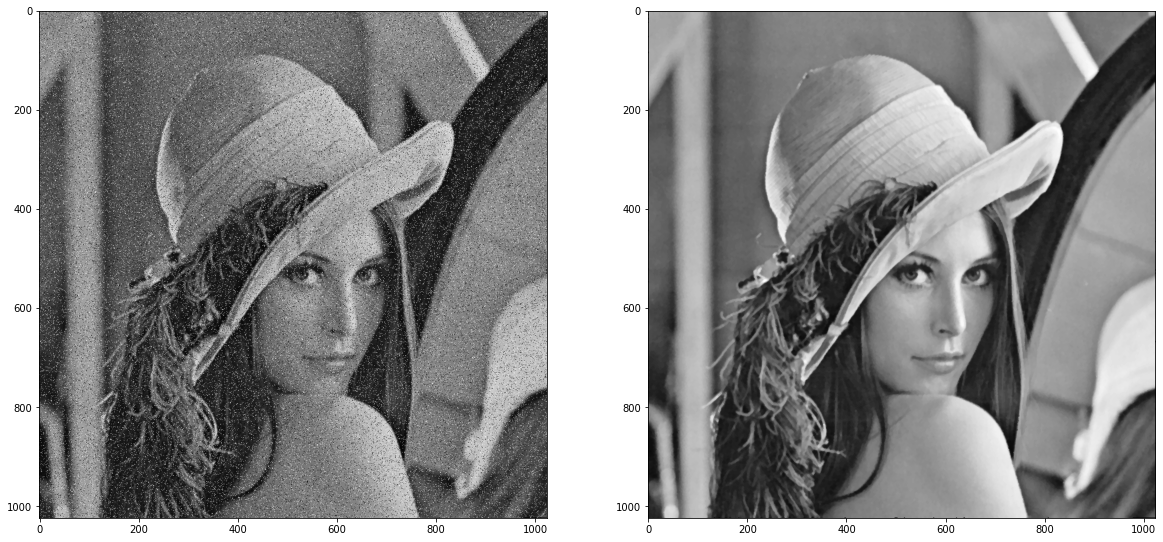

In [ ]:
# Mostrar resultado
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread('/content/3dpl_cuda_colab/lena_1024_noise.bmp'), cmap="gray")
if os.path.isfile('/content/3dpl_cuda_colab/lena_1024_median.bmp') :
  plt.subplot(1, 2, 2)
  plt.imshow(mpimg.imread('/content/3dpl_cuda_colab/lena_1024_median.bmp'), cmap="gray")

## Resetear el entorno y otros

In [ ]:
# Borrar compilación, ejecutable y resultados
!rm -f /content/3dpl_cuda_colab/bin/* /content/3dpl_cuda_colab/filtro_mediana /content/3dpl_cuda_colab/lena_1024_median.bmp

In [ ]:
# Borrar todo el proyecto
!rm -r /content/3dpl_cuda_colab

In [ ]:
# Compilación sin makefile
!nvcc -c /content/3dpl_cuda_colab/src/median.cu -o /content/3dpl_cuda_colab/bin/median.o
!g++  -c /content/3dpl_cuda_colab/src/EasyBMP.cpp -o /content/3dpl_cuda_colab/bin/EasyBMP.o
!g++  /content/3dpl_cuda_colab/bin/median.o /content/3dpl_cuda_colab/bin/EasyBMP.o -o /content/3dpl_cuda_colab/filtro_mediana -I/usr/local/cuda/include -L/usr/local/cuda/lib64 -lcudart

# Preguntas a responder sobre la práctica

**Sobre transferencias CPU-GPU**

* **¿Qué cambio se ha tenido que realizar al final de cada iteración del filtro?**
> Aquí la respuesta

* **¿Qué conseguimos con este cambio?**
> Aquí la respuesta


**Sobre los cambios entre el primer y segundo kernel**
* **¿Qué cambia (conceptualmente) de un kernel a otro?**
> Aquí la respuesta

* **¿Por qué debería funcionar mejor el segundo?**
> Aquí la respuesta


**Sobre el kernel en 2D**

* **¿En qué consiste la planificación de los hilos en este kernel?**
> Aquí la respuesta

* **¿Por qué crees que el rendimiento mejorará con este enfoque?**
> Aquí la respuesta

* **¿De qué forma hay que calcular en el hilo el índice de la fila y la columna del píxel correspondiente?**
> Aquí la respuesta

**Sobre la comparativa entre distintas configuraciones de tamaño de Grid y Bloque**

* **¿Cuál ha funcionado mejor? ¿Por qué (analizar según las características de la gráfica)?**
> Aquí la respuesta

**Extra: Memoria compartida**

* **Explicar cómo se ha intentado resolver el problema.**
> Aquí la respuesta

# Entrega

Para la entrega de esta práctica se deberá compartir el enlace a la copia personal de cada alumno del cuaderno de Google Colab. Para obtenerlo, se debe pulsar en el botón `Compartir` (`Share`), arriba a la derecha, y en el apartado de `Obtener enlace`, seleccionar la opción de `Copiar enlace`. Hay que asegurarse de que el enlace está configurado para que cualquiera con el enlace pueda acceder al contenido (si usamos el GCloud de la UA, basta con la opción de usuarios de la UA), y debe compartirse con permisos de Lector.

El fichero a subir en la entrega de UACloud debe ser un txt llamado `entrega-cuda-p2.txt` cuyo único contenido sea el enlace al cuaderno de Google Colab. De nuevo, el único contenido del txt debe ser el enlace al cuaderno (el proceso para recuperar y agrupar ese enlace de todas las entregas está automatizado con un script).

Por último, debe incluirse el enlace a un breve vídeo recorriendo la práctica, y explicando para los ejercicios del 1 al 3 del guión de la práctica qué se ha ido modificando y cómo dichos cambios van mejorando el código base. Se debe mostrar la ejecución del código para los dos kernels que se han completado para estos ejercicios (el 1D que accede por columnas y permite acceso coalescente, y el 2D). Se deberá mostrar y comentar el pequeño estudio de rendimiento según los tamaños de bloque del ejercicio 4. Por último, si se ha desarrollado el ejercicio 5, explicar el kernel que hace uso de memoria compartida, y en caso de haber conseguido que funcione, ejecutarlo.

Para grabar el vídeo se puede usar cualquier método o herramienta. Se recomienda grabar pantalla, micrófono y webcam para hacerlo lo más parecido posible a una presentación presencial. Existe la herramienta [Loom](https://www.loom.com/) que, a través de un extensión para el navegador, permite grabar la pantalla, la webcam y el micrófono de manera rápida y sencilla, y subiendo el contenido automáticamente y de manera privada a nuestra de cuenta de Loom, de tal forma que compartirlo posteriormente mediante enlace es cuestión de unos pocos clicks. Si se utiliza cualquier otro método, se puede subir el vídeo a Drive o YouTube y facilitar el enlace con los permisos de lectura pertinentes.

**Enlace al Video:**